# PINN for PDEs with two inputs

Here we consider the 1D wave equation with inputs $x$ and $t$, 

$$
 \frac{\partial^2 f}{\partial t^2} - v\cdot \frac{\partial^2 f}{\partial x^2} = 0
$$

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 100  
plt.ioff()


## Defnining a general neural network class

In [11]:
class NN(tf.keras.Model):
    def __init__(
            self, 
            num_inputs: int=1,
            num_hidden_layers: int=1,
            num_neurons: int=1,
            activation: str = 'tanh'
    )->None:
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons

        NNLayers = [tf.keras.layers.Dense(units=num_inputs, input_shape=(self.num_inputs,))] # first layer with input shape specified
        for _ in range(num_hidden_layers - 1):
            NNLayers.append(tf.keras.layers.Dense(units=num_neurons, activation=activation)) # the hidden layers
        NNLayers.append(tf.keras.layers.Dense(units=1)) # the output layer

        self.NNLayers = NNLayers

    def call(
            self,
            input: tf.Tensor
    )->tf.Tensor: # the neural network call implements the forward call, where it runs the input through the first layer, and then feeds the output of the first layer to the second layer and so on
        output = tf.reshape(input, shape=(-1, self.num_inputs))
        for layer in self.NNLayers:
            output = layer(output)
        return output


## Problem specific defninition of the loss function

In [12]:
NUM_LAYERS = 5
NUM_NEURONS = 5
EPOCHS = 5000 #how many times the training step is performed
BATCH_SIZE = 30 # how many input values are considered for each epoch
LEARNING_RATE = 1e-2
TOLERANCE = 5e-4
NUM_INPUTS = 2

V = 2.0
T_DOMAIN = (0.0, 5.0)
X_DOMAIN = (-10.0, 10.0)
T_BOUNDARY = tf.concat([tf.linspace(X_DOMAIN[0], X_DOMAIN[1], BATCH_SIZE)[:, tf.newaxis], tf.fill([BATCH_SIZE,1], 0.0)], axis=1)

In [13]:
def loss_fun(
        model: tf.keras.Model,
        input: tf.Tensor
)->tf.Tensor:
    x = tf.gather(input, [0], axis=1)
    t = tf.gather(input, [1], axis=1)
    with tf.GradientTape(persistent=True) as tape: # required in order to calculate the derivatives
        tape.watch(x)
        tape.watch(t)
        u = model(tf.concat([x,t], axis=1))
        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t) 

    u_xx = tape.gradient(u_x, x) 
    u_tt = tape.gradient(u_t, t) 

    pde = u_tt - V*V*u_xx # the PDE 
    boundary_fun = model(T_BOUNDARY) - tf.math.sin(tf.gather(T_BOUNDARY, [0], axis=1)) # boundary condition sin wave at t=0

    t_boundary_x = tf.gather(T_BOUNDARY, [0], axis=1)
    t_boundary_t = tf.gather(T_BOUNDARY, [1], axis=1)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t_boundary_t)
        u_boundary = model(tf.concat([t_boundary_x, t_boundary_t], axis=1))
    
    u_t_boundary = tape.gradient(u_boundary, t_boundary_t)

    boundary_derivative = u_t_boundary - tf.math.cos(t_boundary_x) # boundary condition for derivative

    interior_loss = tf.reduce_mean(tf.square(pde)) # mean square of the PDE forms the PDE loss
    boundary_loss = tf.reduce_mean(tf.square(boundary_fun) + tf.square(boundary_derivative)) # square of the boundary term forms the boundary loss

    loss = interior_loss + boundary_loss

    return loss

## Training the model!

In [14]:
model = NN(num_inputs=NUM_INPUTS, num_hidden_layers= NUM_LAYERS, num_neurons=NUM_NEURONS)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

def train_step(model, input): # function for one single training step
    with tf.GradientTape() as tape:
        loss = loss_fun(model, input)

    gradients = tape.gradient(loss, model.trainable_variables) # calculate the gradients of the loss with respect to \theta
    optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # optimize the parameters to minimize the loss

    return loss

for epoch in range(EPOCHS):
    input_batch = tf.keras.random.uniform(shape=(BATCH_SIZE, NUM_INPUTS), minval=[X_DOMAIN[0], T_DOMAIN[0]], maxval=[X_DOMAIN[1], T_DOMAIN[1]], dtype=tf.float32) #randomly sample BATCH_SIZE number of points from the domain
    loss = train_step(model, input_batch) # run the train step for the given batch
    if epoch % 50 == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')
    if loss<=TOLERANCE:
        break



d:\Users\adith\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch: 0, Loss: 1.1996546983718872
Epoch: 50, Loss: 0.9841510057449341
Epoch: 100, Loss: 0.909645676612854
Epoch: 150, Loss: 0.7838550806045532
Epoch: 200, Loss: 0.8101662993431091
Epoch: 250, Loss: 0.7727956175804138
Epoch: 300, Loss: 0.6846933960914612
Epoch: 350, Loss: 0.5855420231819153
Epoch: 400, Loss: 0.49697330594062805
Epoch: 450, Loss: 0.4489370584487915
Epoch: 500, Loss: 0.42319974303245544
Epoch: 550, Loss: 0.4073698818683624
Epoch: 600, Loss: 0.37827399373054504
Epoch: 650, Loss: 0.3684524893760681
Epoch: 700, Loss: 0.3618071675300598
Epoch: 750, Loss: 0.32249686121940613
Epoch: 800, Loss: 0.2562156617641449
Epoch: 850, Loss: 0.21445824205875397
Epoch: 900, Loss: 0.20751459896564484
Epoch: 950, Loss: 0.20780056715011597
Epoch: 1000, Loss: 0.2144821733236313
Epoch: 1050, Loss: 0.22774799168109894
Epoch: 1100, Loss: 0.19429512321949005
Epoch: 1150, Loss: 0.2028961032629013
Epoch: 1200, Loss: 0.18991398811340332
Epoch: 1250, Loss: 0.18197543919086456
Epoch: 1300, Loss: 0.1918

## Prediction and Plotting!

In [15]:
DENSITY = 50

x_plot = tf.linspace(X_DOMAIN[0], X_DOMAIN[1], DENSITY)[:, tf.newaxis]
t_plot = tf.linspace(T_DOMAIN[0], T_DOMAIN[1], DENSITY)[:, tf.newaxis]
X_mesh, T_mesh = tf.meshgrid(x_plot, t_plot)
X_pred = tf.reshape(X_mesh, shape=(-1, 1))
T_pred = tf.reshape(T_mesh, shape=(-1, 1))
y_pred = model(tf.concat([X_pred, T_pred], axis=1))

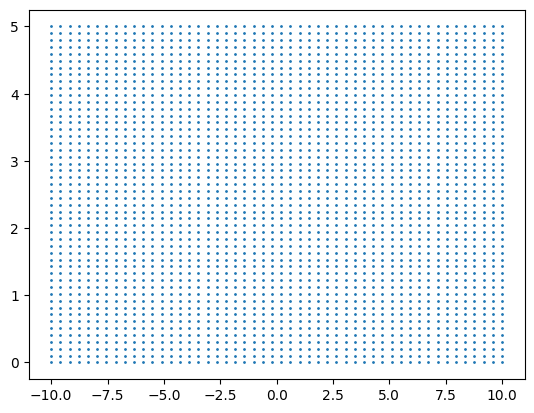

In [16]:
plt.scatter(X_pred, T_pred, s=1)
plt.show()

In [18]:
from time import sleep

fig, ax = plt.subplots()
ax.grid(True)

def animate(i):
    plt.cla()
    plt.plot(x_plot, y_pred[i*DENSITY : (i+1)*DENSITY])
    plt.xlim(X_DOMAIN[0], X_DOMAIN[1])  
    plt.ylim(-2,2)

matplotlib.animation.FuncAnimation(fig, animate, frames=DENSITY)
